In [1]:
import picamera 
import time

# sudo pip3 install和pip3 install的路径不一样，所以pip3 isntall安装的包jupyter访问不到
import sys
sys.path.append('/home/pi/.local/lib/python3.5/site-packages') # 所以要加上这一句

import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.cm as cm # 用于在特定颜色映射中显示图像

from skimage.measure import compare_ssim
import argparse
import imutils

## 图片素材：

### 1 拍摄图片

In [ ]:
# 树莓派500万像素的摄像头
# 全分辨率图像，主要是为了后期输出
img = np.empty((1920 * 2560 * 3,), dtype=np.uint8)
img2 = np.empty((1920 * 2560 * 3,), dtype=np.uint8)
with picamera.PiCamera() as camera:
    camera.resolution = (2560, 1920)
    camera.framerate = 10
    time.sleep(10)
    camera.capture(img, 'bgr')  # opencv用BGR
    img = img.reshape((1920, 2560, 3))
    
    time.sleep(5) # 5秒后拍摄第二张
    
    camera.capture(img2, 'bgr')  # opencv用BGR
    img2 = img2.reshape((1920, 2560, 3))

In [ ]:
# 低分辨率图像
img = np.empty((240 * 320 * 3,), dtype=np.uint8)
img2 = np.empty((240 * 320 * 3,), dtype=np.uint8)
with picamera.PiCamera() as camera:
    camera.resolution = (320, 240)
    camera.framerate = 10
    time.sleep(10)
    camera.capture(img, 'bgr')  # opencv用BGR
    img = img.reshape((240, 320, 3))
    
    time.sleep(5)
    
    camera.capture(img2, 'bgr')  # opencv用BGR
    img2 = img2.reshape((240, 320, 3))

### 2 从文件导入图片

In [2]:
img=cv2.imread('image.png')
img2=cv2.imread('image2.png')

### 输出图片

Text(0.5, 1.0, 'pic2')

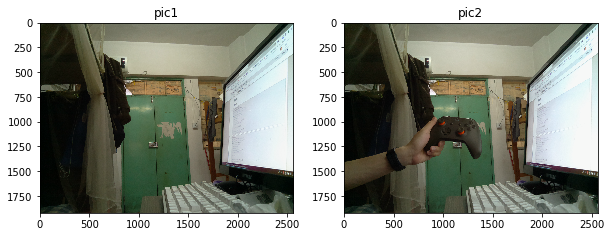

In [3]:
# 输出图片
plt.figure(figsize=(10,5)) 
plt.subplot(1,2,1)
plt.imshow(img[...,::-1]) # 转RGB
plt.title('pic1')
plt.subplot(1,2,2)
plt.imshow(img2[...,::-1])
plt.title('pic2')

In [ ]:
# 保存图片
cv2.imwrite('image.png', img)
cv2.imwrite('image2.png', img2)

### 图片预处理

In [4]:
# 缩放
image=cv2.resize(img, (320, 240), interpolation=cv2.INTER_CUBIC)
image2=cv2.resize(img2, (320, 240), interpolation=cv2.INTER_CUBIC)

# 转灰度
image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image2=cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# 高斯模糊 可以很大程度上减少噪点造成的影响
image = cv2.GaussianBlur(image, (5, 5), 0)
image2 = cv2.GaussianBlur(image2, (5, 5), 0)

# 图片对比
### 方法1 直接通过计算差值判断图片相似性
在强光照高对比环境中似乎不太可靠

In [5]:
# 计算差值绝对值
image3=cv2.absdiff(image,image2)

# 二值化
image3 = cv2.threshold(image3, 25, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
print('Different pixels:',image3[image3=0].size,'of',image3.size)
diffRate=image3[image3=0].size/image3.size
print('DiffRate=',diffRate)

if diffRate>0.01:
    print('They are different.')
else:
    print('They are same.')

Different pixels: 4112 of 76800
DiffRate= 0.0535416666666667
They are different.


Text(0.5, 1.0, 'diff')

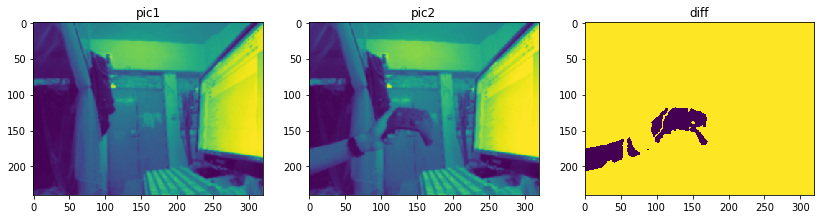

In [6]:
# 输出对比图
plt.figure(figsize=(14,6)) 
plt.subplot2grid((1,3),(0,0))
plt.imshow(image)
plt.title('pic1')
plt.subplot2grid((1,3),(0,1))
plt.imshow(image2)
plt.title('pic2')
plt.subplot2grid((1,3),(0,2))
plt.imshow(image3)
plt.title('diff')

### 方法2 通过计算图像之间的结构相似度(SSIM)指数来判断

#### compare_ssim(X, Y, win_size=None, gradient=False, data_range=None, multichannel=False, gaussian_weights=False, full=False, **kwargs)  比较SSIM (Structural SIMilarity) 结构相似性

#### cv2.threshold (src, thresh, maxval, type) 阈值处理
- src：源图片，必须是单通道
- thresh：阈值，取值范围0～255
- maxval：填充色，取值范围0～255
- type：阈值类型，具体见下表  
type后接cv2.THRESH_OTSU时，表示自动选择合适的阈值

| 阈值类型 | 小于阈值的像素点 |	大于阈值的像素点 |
| -------- | ---------------- | ---------------- |
| 0	     | 置0          | 置填充色       |
| 1	     | 置填充色       | 置0         |
| 2	     | 保持原色       | 置灰色       |
| 3	     | 置0          | 保持原色       |
| 4	     | 保持原色       | 置0         |



#### cv2.findContours(image, mode, method[, contours[, hierarchy[, offset ]]])  查找检测物体的轮廓
注意，findcontours函数会“原地”修改输入的图像。
- image: 寻找轮廓的图像
- mode: 轮廓的检索模式
 - cv2.RETR_EXTERNAL表示只检测外轮廓
 - cv2.RETR_LIST检测的轮廓不建立等级关系
 - cv2.RETR_CCOMP建立两个等级的轮廓，上面的一层为外边界，里面的一层为内孔的边界信息。如果内孔内还有一个连通物体，这个物体的边界也在顶层。
 - cv2.RETR_TREE建立一个等级树结构的轮廓
- method: 轮廓的近似办法
 - cv2.CHAIN_APPROX_NONE存储所有的轮廓点，相邻的两个点的像素位置差不超过1，即max（abs（x1-x2），abs（y2-y1））==1
 - cv2.CHAIN_APPROX_SIMPLE压缩水平方向，垂直方向，对角线方向的元素，只保留该方向的终点坐标，例如一个矩形轮廓只需4个点来保存轮廓信息
 - cv2.CHAIN_APPROX_TC89_L1，CV_CHAIN_APPROX_TC89_KCOS使用teh-Chinl chain 近似算法
- 返回值：一个是轮廓本身，还有一个是每条轮廓对应的属性

#### cv2.rectangle(图片，左上坐标，右下坐标，color（BGR）,线宽) 画长方形
#### cv2.putText(thresh, okText, (10, 230), font, 1, (255, 255, 255), 1)
 图像，文字内容， 坐标 ，字体，大小，颜色，字体厚度

In [7]:
# 计算ssim
(score,diff) = compare_ssim(image,image2,full = True)
diff = (diff *255).astype("uint8")
print("SSIM:{}".format(score))

SSIM:0.9140822389861617


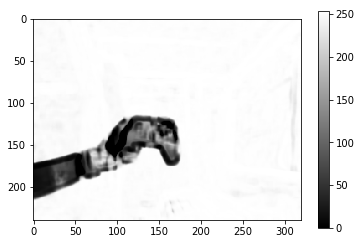

In [8]:
plt.figure(figsize=(6,4)) 
plt.imshow(diff,cmap="gray")
plt.colorbar()

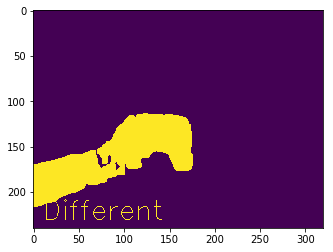

In [9]:
# 找到轮廓
if score>0.98:
    okText='Same'
    print(okText)
else:
    okText='Different'
    # 二值化 找到不同点的轮廓
    thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # 扩展阀值图像填充孔洞，然后找到阀值图像上的轮廓
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]

    font = cv2.FONT_HERSHEY_SIMPLEX
    imgzi = cv2.putText(thresh, okText, (10, 230), font, 1, (255, 255, 255), 1) # 图像，文字内容， 坐标 ，字体，大小，颜色，字体厚度
    
    plt.figure(figsize=(6,4)) 
    plt.imshow(imgzi)


In [10]:
# 用长方形圈出不同点
for c in cnts:
    (x,y,w,h) = cv2.boundingRect(c)
    cv2.rectangle(image2,(x,y),(x+w,y+h),(255,255,255),1)
image2 = cv2.putText(image2, okText, (10, 230), font, 1, (255, 255, 255), 1)

Text(0.5, 1.0, 'pic2')

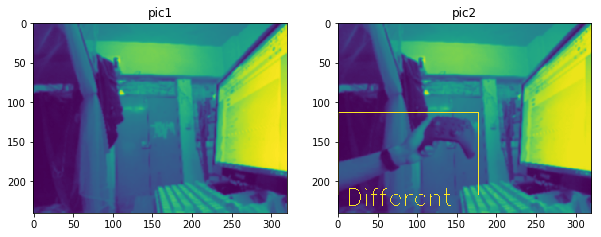

In [11]:
# 输出结果
plt.figure(figsize=(10,5)) 
plt.subplot2grid((1,2),(0,0))
plt.imshow(image)
plt.title('pic1')
plt.subplot2grid((1,2),(0,1))
plt.imshow(image2)
plt.title('pic2')

Text(0.5, 1.0, 'pic2')

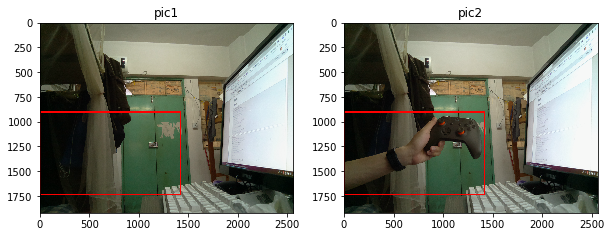

In [12]:
# 输出全尺寸对比图
image=img
image2=img2

for c in cnts:
    (x,y,w,h) = cv2.boundingRect(c)
    x*=8
    y*=8
    w*=8
    h*=8
    cv2.rectangle(image2,(x,y),(x+w,y+h),(0,0,255),10)
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,0,255),10)

# 输出结果
plt.figure(figsize=(10,5)) 
plt.subplot2grid((1,2),(0,0))
plt.imshow(image[...,::-1])
plt.title('pic1')
plt.subplot2grid((1,2),(0,1))
plt.imshow(image2[...,::-1])
plt.title('pic2')